In [20]:
import pandas as pd
import csv
import numpy as np
import os

# Dictionaries

In [21]:
# Change the values that need to be changed manually here
station_coord_rects = {
    'Xavier Hall': { 
        'Latitude': { 
            'lower': 14.640004,
            'higher': 14.640371
        },
        'Longitude': { 
            'lower': 121.078251,
            'higher': 121.078789
        }
    },
    'Fine Arts Annex': { 
        'Latitude': { 
            'lower': 14.636606,
            'higher': 14.636749
        },
        'Longitude': { 
            'lower': 121.078116,
            'higher': 121.078324
        }
    },
    'Loyola House of Studies': { 
        'Latitude': { 
            'lower': 14.636115,
            'higher': 14.636302
        },
        'Longitude': { 
            'lower': 121.080644,
            'higher': 121.080738
        }
    },
    'Grade School': { 
        'Latitude': { 
            'lower': 14.634715,
            'higher': 14.634715
        },
        'Longitude': { 
            'lower': 121.076171,
            'higher': 121.076326
        }
    },
    'JSEC': { 
        'Latitude': { 
            'lower': 14.637686,
            'higher': 14.637804
        },
        'Longitude': { 
            'lower': 121.076260,
            'higher': 121.076370
        }
    },
    'Gate 2.5': { 
        'Latitude': { 
            'lower': 14.637874,
            'higher': 14.637927
        },
        'Longitude': { 
            'lower': 121.074848,
            'higher': 121.075020
        }
    },
    'Leong Hall': { 
        'Latitude': { 
            'lower': 14.640724,
            'higher': 14.640864
        },
        'Longitude': { 
            'lower': 121.076177,
            'higher': 121.076395
        }
    },
    'Power Station': { 
        'Latitude': { 
            'lower': 14.635504,
            'higher': 14.635692
        },
        'Longitude': { 
            'lower': 121.074559,
            'higher': 121.074674
        }
    },
}

In [22]:
next_station_dict = { 
    'Xavier Hall': 'Fine Arts Annex',
    'Fine Arts Annex': 'Loyola House of Studies',
    'Loyola House of Studies': 'Grade School',
    'Grade School': 'Gate 2.5',
    'Gate 2.5': 'Leong Hall',
    'Leong Hall': 'Xavier Hall'
}

# Functions

In [23]:
from datetime import time, datetime

def time_to_daytimestamp(stamp: str) -> int:
    # Handling None or float inputs
    if stamp is None or isinstance(stamp, float):
        return -1
    
    # If stamp is a datetime.datetime object
    if isinstance(stamp, datetime):
        year_seconds = stamp.year * 365 * 24 * 3600  # Assuming average year length
        month_seconds = stamp.month * 30 * 24 * 3600  # Assuming average month length
        day_seconds = stamp.day * 24 * 3600
        return year_seconds + month_seconds + day_seconds + stamp.hour * 3600 + stamp.minute * 60 + stamp.second
    
    # If stamp is a datetime.time object, you can directly access hours, minutes, and seconds
    if isinstance(stamp, time):
        return stamp.hour * 3600 + stamp.minute * 60 + stamp.second

    # If stamp is a string in "HH:MM:SS" format
    h, m, s = stamp.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [24]:
# Reformat Lat and Long to be decimal coordinates
def ddmm_mmmm_to_decimal(coord):
    # Assuming coord is in the format 'ddmm.mmmm'
    
    # Extract degrees and decimal minutes
    degrees = coord // 100
    decimal_minutes = coord % 100
    
    # Convert decimal minutes to decimal degrees
    decimal_degrees = degrees + decimal_minutes / 60
    
    return decimal_degrees

In [25]:
# Label stations along the line that the ejeep is in based on coordinates
def coord_to_station(lat, long) -> str:
    stations = station_coord_rects.keys()

    for station in stations:
        lat_bounds, long_bounds = station_coord_rects[station]['Latitude'], station_coord_rects[station]['Longitude']

        if (lat >= lat_bounds['lower'] - 0.0003 and lat <= lat_bounds['higher'] + 0.0003) and (long >= long_bounds['lower'] - 0.0003 and long <= long_bounds['higher'] + 0.0003):
            return station
    else:
        return "En Route"

In [26]:
import math

# Function to calculate distance using Haversine formula
def haversine_distance(lat_diff, lon_diff):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude differences from degrees to radians
    lat_diff_rad = math.radians(lat_diff)
    lon_diff_rad = math.radians(lon_diff)

    # Haversine formula
    a = math.sin(lat_diff_rad / 2)**2 + math.cos(0) * math.cos(0) * math.sin(lon_diff_rad / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Calculate distance
    distance = R * c

    return distance * 1000

In [27]:
# Make dictionary of all stations & average lat & long
def station_centroids(coord) -> dict:
    new_dict = dict()

    new_dict['En Route'] = None

    for station in station_coord_rects:
        ave = (station_coord_rects[station][coord]['lower'] + station_coord_rects[station][coord]['higher']) / 2

        new_dict[station] = ave
    
    return new_dict

lat_centers = station_centroids('Latitude')
long_centers = station_centroids('Longitude')

lat_centers
long_centers

{'En Route': None,
 'Xavier Hall': 121.07852,
 'Fine Arts Annex': 121.07821999999999,
 'Loyola House of Studies': 121.080691,
 'Grade School': 121.07624849999999,
 'JSEC': 121.076315,
 'Gate 2.5': 121.074934,
 'Leong Hall': 121.07628600000001,
 'Power Station': 121.07461649999999}

In [28]:
# Define Prev Station
def prev_station(df):
    df['Prev Station'] = df['Station']
    df.loc[df['Station'] == 'En Route', "Prev Station"] = np.nan

    df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
    df.loc[df['Station'] != 'En Route', "Prev Station"] = np.nan
    df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
    df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
    
    return df

In [29]:
# Define Next Station
def next_station(df):
    df['Next Station'] = df['Station']
    df.loc[df['Station'] == 'En Route', "Next Station"] = np.nan

    df['Next Station'] = df['Next Station'].fillna(method='bfill')
    df.loc[df['Station'] != 'En Route', "Next Station"] = np.nan
    df['Next Station'] = df['Next Station'].fillna(method='bfill')
    df['Next Station'] = df['Next Station'].fillna(method='ffill')
    
    return df

In [30]:
# Previous & Next Times

def prev_next_times(df):
    # Create a 2nd df that's a more compiled version of the table for easier look-ups

    df2 = pd.DataFrame(columns=['Original Index', 'Station', 'Time'])

    next_station = ''

    for index, row in df.iterrows():
        if row['Station'] == 'En Route' or row['Station'] == 'Power Station':
            continue

        # Log the first instance of the ejeep getting to the stop
        if row['Station'] == next_station or next_station == '':
            new_row = {
                'Original Index': index,
                'Station': row['Station'],
                'Time': row['Time']
            }
            df2.loc[len(df2)] = new_row

            next_station = next_station_dict[row['Station']]
            
    # This essentially notes when the e-jeep arrives and leaves at the station

    df_stations_sum = pd.DataFrame(columns=['Original Index', 'Station', 'Time', 'Status'])

    df_stations_sum = pd.DataFrame(columns=['Original Index', 'Station', 'Time', 'Status'])

    previous_index = None
    previous_station = 'En Route'
    previous_time = None

    for index, row in df.iterrows():
        current_time, current_station = row['Time'], row['Station']

        if previous_station == 'En Route' and current_station == 'En Route':
            continue

        if previous_station == 'En Route' and current_station != 'En Route':
            # Arrived at the station
            new_row = { 
                'Original Index': index,
                'Station': current_station,
                'Time': current_time,
                'Status': 'Arriving'
            }

            df_stations_sum.loc[len(df_stations_sum)] = new_row
        
        if previous_station != 'En Route' and current_station == 'En Route':
            # Departed from the station
            new_row = { 
                'Original Index': previous_index,
                'Station': previous_station,
                'Time': previous_time,
                'Status': 'Departing'
            }

            df_stations_sum.loc[len(df_stations_sum)] = new_row
        
        previous_time, previous_index, previous_station = current_time, index, current_station
    
    df['Previous Time to Xavier Hall'] = None
    df['Previous Time to Fine Arts Annex'] = None
    df['Previous Time to Loyola House of Studies'] = None
    df['Previous Time to Grade School'] = None
    df['Previous Time to Gate 2.5'] = None
    df['Previous Time to Leong Hall'] = None

    df['Next Time to Xavier Hall'] = None
    df['Next Time to Fine Arts Annex'] = None
    df['Next Time to Loyola House of Studies'] = None
    df['Next Time to Grade School'] = None
    df['Next Time to Gate 2.5'] = None
    df['Next Time to Leong Hall'] = None
    
    df2 = df_stations_sum.copy()

    for index, row in df2.iterrows():
        future_df = df2.iloc[index + 1: index + 40]
        prev_df = df2.iloc[max(index - 40, 0): max(0, index - 1)]

        if row['Status'] == 'Departing':
            for station in next_station_dict.keys():
                future_df_index = future_df.index.where(future_df['Station'] == station).min()
                if not pd.isnull(future_df_index):
                    future_df_index = int(future_df_index)
                    df.at[row['Original Index'], f'Next Time to {station}'] = df2.at[future_df_index, 'Time']
        elif row['Status'] == 'Arriving':
            for station in next_station_dict.keys():
                prev_df_index = prev_df.index.where(prev_df['Station'] == station).max()
                if not pd.isnull(prev_df_index):
                    prev_df_index = int(prev_df_index)
                    df.at[row['Original Index'], f'Previous Time to {station}'] = df2.at[prev_df_index, 'Time']
                    
    df = df.dropna(how='all')
    
    for station in next_station_dict.keys():
        df[f'Previous Time to {station}'] = df[f'Previous Time to {station}'].interpolate(method='ffill', limit_direction='forward')
        df[f'Next Time to {station}'] = df[f'Next Time to {station}'].interpolate(method='bfill', limit_direction='backward')
    
    return df

In [65]:
def process_station(file_path):
     df = pd.read_csv(file_path)
     df.tail(10)

     df.columns = ['Type', 'Datetime', 'Lat', 'Long', 'Altitude', 'Humidity', 'Temperature']
     df.drop(columns='Type', inplace=True)

     # Drop rows with null at start and end
     # df = df.loc[df.notnull().all(axis=1).argmax():]

     # ids = df[df.notnull().all(axis=1)].index
     # last_id = ids[-1]

     # df = df.loc[:last_id]
            
     # Fix time to PHT
     log_date = os.path.basename(file_path).split('/')[-1]
     df['Datetime'] = pd.to_datetime(df['Datetime'], format='mixed')
     df['Datetime'] = df['Datetime'].dt.tz_convert('+08:00')
     df['Datetime'] = pd.to_datetime(df['Datetime'].dt.strftime(f"{log_date[5:15]} %H:%M:%S"))
     
     # Create a DataFrame with a time range for every second between 6am and 6pm
     time_range = pd.date_range(log_date[5:15] + " 06:00:00", log_date[5:15] + " 18:00:00", freq='S')
     expected_df = pd.DataFrame({'Datetime': time_range})
     expected_df['Datetime'] = pd.to_datetime(expected_df['Datetime'])

     # Merge the expected DataFrame with your original DataFrame on the 'time' column
     df = pd.merge(expected_df, df, on='Datetime', how='left')
     
     # Extract Time
     df['Time'] = df['Datetime'].dt.time
     
     # Extract Day
     df['Day'] = df['Datetime'].dt.day

     # Add day of week
     df['Day_of_Week'] = df['Datetime'].dt.day_name()
            
     # Add hour of day
     df['Hour_of_Day'] = df['Datetime'].dt.hour
     
     # Filter out rows before 6am and after 6pm
     df = df.loc[(df['Hour_of_Day'] >= 6) & (df['Hour_of_Day'] <= 18)]

     # Get One Hot Encoded E-Jeep ID
     ejeep_id = file_path.split('/')[1]
     df['IsEJeep1'] = 0
     df['IsEJeep2'] = 0
     df[f"IsEJeep{ejeep_id[5]}"] = 1

     # Iterpolate values for NaN GPS values
     df['Lat'] = df['Lat'].astype(float).interpolate(method='linear', limit_direction='both') 
     df['Long'] = df['Long'].astype(float).interpolate(method='linear', limit_direction='both') 
     df['Altitude'] = df['Altitude'].astype(float).interpolate(method='linear', limit_direction='both') 
     df['Temperature'] = df['Temperature'].astype(float).interpolate(method='linear', limit_direction='both') 
     df['Humidity'] = df['Humidity'].astype(float).interpolate(method='linear', limit_direction='both') 
            
     df['Latitude'] = df.apply(lambda row: ddmm_mmmm_to_decimal(row['Lat']), axis=1)
     df['Longitude'] = df.apply(lambda row: ddmm_mmmm_to_decimal(row['Long']), axis=1)

     # Drop old Lat / Long values
     df.drop(columns=['Lat', 'Long'], inplace=True)
            
     df['Station'] = df.apply(lambda row: coord_to_station(row['Latitude'], row['Longitude']), axis=1)
            
     # Calculate speed (noted as distance since it's by second anyway) based on change in coordinates from the previous
     # Helps establish if ejeep is truly within station

     df['Lat Diff'] = df['Latitude'].diff()
     df['Long Diff'] = df['Longitude'].diff()

     df['Distance'] = df.apply(lambda row: haversine_distance(row['Lat Diff'], row['Long Diff']), axis=1)
     
     df['Lat Diff'] = df['Lat Diff'].fillna(0)
     df['Long Diff'] = df['Long Diff'].fillna(0)
     df['Distance'] = df['Distance'].fillna(0)
     
     df['Station'] = df.apply(lambda row: 'En Route' if row['Station'] != 'En Route' and row['Distance'] >= 0.6 else row['Station'], axis=1)
            
     # Add station column that's true if in station, false if en route
     df["IsStation"] = 0
     df.loc[(df["Station"] != "En Route") & (df["Station"] != "Power Station"), "IsStation"] = 1
     
     # Drop rows before first and last station of each day
     # id_not_null = df.notnull().all(axis=1).idxmax()
     # start = df.loc[df.IsStation==1,'IsStation'].index[0] - id_not_null
     # end = df.query('IsStation == 1').index.max()+1
     # df = df.iloc[start:end]
     
     df = prev_station(df)
     df = next_station(df)
            
     # Filter out repeated stations
     df['Station'] = df.apply(lambda x: x['Next Station'] if x['Station'] == 'En Route' and x['Prev Station'] == x['Next Station'] else x['Station'], axis=1)
     df = prev_station(df)
     df = next_station(df)
            
     df = prev_next_times(df)
     print("done with " + log_date)
     return df

In [144]:
# df = process_station("E-Jeep Data/ejeep2/data_2023-12-01_2.csv")
# df

# Raw Data
* Combine csv files from each rpi into one data frame
* Pre-process raw data

In [66]:
# Create a list to hold the dataframes
df_list = []

stuffs = dict()

for i in range(2):
    i = i + 1
    folder_path = os.path.join('E-Jeep Data', f"ejeep{i}")
    all_files = os.listdir(folder_path)
    
    # Filter out non-CSV files
    csv_files = [f for f in all_files if f.endswith('.csv')]
    
    for csv in csv_files:
        file_path = os.path.join(folder_path, csv)
        try:
            # Try reading the file using default UTF-8 encoding
            df = process_station(file_path)
            stuffs[file_path] = df.isna().sum()
            df_list.append(df)
        except UnicodeDecodeError:
            try:
                # If UTF-8 fails, try reading the file using UTF-16 encoding with tab separator
                df = pd.read_csv(file_path, sep='\t', encoding='utf-16')
                df_list.append(df)
            except Exception as e:
                print(f"Could not read file {csv} because of error: {e}")
        except Exception as e:
            print(f"Could not read file {csv} because of error: {e}")

# Concatenate all data into one DataFrame
df = pd.concat(df_list, ignore_index=True)
df

/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-17_1.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-28_1.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-15_1.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-30_1.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-14_1.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-29_1.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-16_1.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-10.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-09.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-28_2.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-15_2.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-17_2.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-16_2.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-30_2.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-14_2.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-29_2.csv


/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='ffill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3679190830.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev Station'] = df['Prev Station'].fillna(method='bfill')
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/3185133074.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

done with data_2023-11-11.csv


,Datetime,Altitude,Humidity,Temperature,Time,Day,Day_of_Week,Hour_of_Day,IsEJeep1,IsEJeep2,...,Previous Time to Loyola House of Studies,Previous Time to Grade School,Previous Time to Gate 2.5,Previous Time to Leong Hall,Next Time to Xavier Hall,Next Time to Fine Arts Annex,Next Time to Loyola House of Studies,Next Time to Grade School,Next Time to Gate 2.5,Next Time to Leong Hall
0,2023-11-17 06:00:00,63.7,79.199997,29.299999,06:00:00,17,Friday,6,1,0,...,None,None,None,None,06:18:02,06:48:05,06:21:45,06:06:27,06:55:48,06:12:32
1,2023-11-17 06:00:01,63.5,79.199997,29.299999,06:00:01,17,Friday,6,1,0,...,None,None,None,None,06:18:02,06:48:05,06:21:45,06:06:27,06:55:48,06:12:32
2,2023-11-17 06:00:02,63.3,79.199997,29.299999,06:00:02,17,Friday,6,1,0,...,None,None,None,None,06:18:02,06:48:05,06:21:45,06:06:27,06:55:48,06:12:32
3,2023-11-17 06:00:03,63.0,79.199997,29.299999,06:00:03,17,Friday,6,1,0,...,None,None,None,None,06:18:02,06:48:05,06:21:45,06:06:27,06:55:48,06:12:32
4,2023-11-17 06:00:04,62.7,79.199997,29.299999,06:00:04,17,Friday,6,1,0,...,None,None,None,None,06:18:02,06:48:05,06:21:45,06:06:27,06:55:48,06:12:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772387,2023-11-11 17:59:56,75.0,80.400002,30.799999,17:59:56,11,Saturday,17,0,1,...,09:36:27,09:42:03,09:44:33,09:46:41,None,None,None,None,None,None
772388,2023-11-11 17:59:57,75.0,80.400002,30.799999,17:59:57,11,Saturday,17,0,1,...,09:36:27,09:42:03,09:44:33,09:46:41,None,None,None,None,None,None
772389,2023-11-11 17:59:58,75.0,80.400002,30.799999,17:59:58,11,Saturday,17,0,1,...,09:36:27,09:42:03,09:44:33,09:46:41,None,None,None,None,None,None
772390,2023-11-11 17:59:59,75.0,80.400002,30.799999,17:59:59,11,Saturday,17,0,1,...,09:36:27,09:42:03,09:44:33,09:46:41,None,None,None,None,None,None


In [62]:
stuffs

{'E-Jeep Data/ejeep1/data_2023-11-17_1.csv': Datetime                                       0
 Altitude                                       0
 Humidity                                       0
 Temperature                                    0
 Time                                           0
 Day                                            0
 Day_of_Week                                    0
 Hour_of_Day                                    0
 IsEJeep1                                       0
 IsEJeep2                                       0
 Latitude                                       0
 Longitude                                      0
 Station                                        0
 Lat Diff                                       0
 Long Diff                                      0
 Distance                                       0
 IsStation                                      0
 Prev Station                                   0
 Next Station                                   0
 Previ

In [59]:
null_df = df[df['Latitude'].isna()][['Datetime']]

In [67]:
df.isna().sum()

Datetime                                         0
Altitude                                         0
Humidity                                         0
Temperature                                      0
Time                                             0
Day                                              0
Day_of_Week                                      0
Hour_of_Day                                      0
IsEJeep1                                         0
IsEJeep2                                         0
Latitude                                         0
Longitude                                        0
Station                                          0
Lat Diff                                         0
Long Diff                                        0
Distance                                         0
IsStation                                        0
Prev Station                                     0
Next Station                                     0
Previous Time to Xavier Hall   

In [34]:
df['Latitude'].min()

14.630133333333333

In [68]:
# Sort by datetime
df = df.sort_values(by=['Day', 'IsEJeep2', 'Time'], ascending=True)

# Data Processing

In [69]:
# Add IsCharging column: true if charging, false otherwise
df['IsCharging'] = 0

df.loc[df['Station'] == 'Power Station', "IsCharging"] = 1

In [70]:
# Add distances (by road) to next station
df['Cum Distance'] = df[::-1].groupby((df['Station'] != 'En Route').cumsum())['Distance'].cumsum()
df.loc[df['Station'] != 'En Route', 'Cum Distance'] = 0

df.dtypes


Datetime                                    datetime64[ns]
Altitude                                           float64
Humidity                                           float64
Temperature                                        float64
Time                                                object
Day                                                  int32
Day_of_Week                                         object
Hour_of_Day                                          int32
IsEJeep1                                             int64
IsEJeep2                                             int64
Latitude                                           float64
Longitude                                          float64
Station                                             object
Lat Diff                                           float64
Long Diff                                          float64
Distance                                           float64
IsStation                                            int

In [71]:
# Add distances (as the bird flies) to next station
df['Next Station Lat'] = df['Next Station'].map(lat_centers)
df['Next Station Long'] = df['Next Station'].map(long_centers)

df['Abs Distance'] = df.apply(lambda row: haversine_distance(row['Next Station Lat'] - row['Latitude'], row['Next Station Long'] - row['Longitude']), axis=1)

In [72]:
# Do percentage of distance remaining to next station

# Calculate the maximum value of C within each group of 'X'
max_distance_per_group = df[df['Station'] == 'En Route'].groupby((df['Station'] != 'En Route').cumsum())['Cum Distance'].transform('max')

# Add column D representing the percentage of each value in column C relative to the maximum value within its group
df['Percent Distance'] = df['Cum Distance'] / max_distance_per_group * 100

df.dtypes


Datetime                                    datetime64[ns]
Altitude                                           float64
Humidity                                           float64
Temperature                                        float64
Time                                                object
Day                                                  int32
Day_of_Week                                         object
Hour_of_Day                                          int32
IsEJeep1                                             int64
IsEJeep2                                             int64
Latitude                                           float64
Longitude                                          float64
Station                                             object
Lat Diff                                           float64
Long Diff                                          float64
Distance                                           float64
IsStation                                            int

In [73]:
# Add distance (as the crow flies) to the previous station
df['Prev Station Lat'] = df['Prev Station'].map(lat_centers)
df['Prev Station Long'] = df['Prev Station'].map(long_centers)

df['Prev Abs Distance'] = df.apply(lambda row: haversine_distance(row['Prev Station Lat'] - row['Latitude'], row['Prev Station Long'] - row['Longitude']), axis=1)

In [74]:
# Add distance (by road) to the previous station
df['Prev Cum Distance'] = df.groupby((df['Station'] != 'En Route').cumsum())['Distance'].cumsum()
df.loc[df['Station'] != 'En Route', 'Prev Cum Distance'] = 0

In [153]:
# Global variables


# Average speed every 10 seconds

# Average, min, max temp & humidity in between stations



# Ordinal Encoding

In [75]:
df['Prev Station'] = df['Prev Station'].replace(np.nan, 'Power Station')
df['Next Station'] = df['Next Station'].replace(np.nan, 'Power Station')

In [76]:
# Day of Week
df.sort_values('Day_of_Week')
df['Encoded Day'] = pd.factorize(df['Day_of_Week'])[0] + 1

In [77]:
route = ['En Route', 'Grade School', 'JSEC', 'Gate 2.5', 'Leong Hall', 'Xavier Hall', 'University Dormitory', 'Fine Arts Annex', 'Loyola House of Studies', 'Gate 1', 'Power Station']

# Station
df['Encoded Station'] = df['Station'].apply(lambda x: route.index(x))

# Prev Station
df['Encoded Prev Station'] = df['Prev Station'].apply(lambda x: route.index(x))

# Next Station
df['Encoded Next Station'] = df['Next Station'].apply(lambda x: route.index(x))

In [78]:
df.drop(columns='Day_of_Week', inplace=True)
df.drop(columns='Station', inplace=True)
df.drop(columns='Prev Station', inplace=True)
df.drop(columns='Next Station', inplace=True)

In [79]:
# Rearrange columns

df = df[['Datetime', 'Day', 'Encoded Day', 'Time', 'Hour_of_Day', 'IsEJeep1', 'IsEJeep2', 'Altitude', 'Humidity', 
         'Temperature', 'Latitude', 'Longitude', 'Lat Diff', 'Long Diff', 'Distance',  'Cum Distance', 'Abs Distance', 'Percent Distance', 
         'Encoded Station', 'IsStation', 'IsCharging', 
         'Encoded Prev Station', 'Prev Station Lat', 'Prev Station Long', 'Prev Abs Distance', 'Prev Cum Distance', 
         'Previous Time to Xavier Hall', 'Previous Time to Fine Arts Annex', 'Previous Time to Loyola House of Studies',
         'Previous Time to Grade School', 'Previous Time to Gate 2.5', 'Previous Time to Leong Hall', 
         'Encoded Next Station', 'Next Station Lat', 'Next Station Long', 'Next Time to Xavier Hall', 'Next Time to Fine Arts Annex', 
         'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 
        ]]

df

,Datetime,Day,Encoded Day,Time,Hour_of_Day,IsEJeep1,IsEJeep2,Altitude,Humidity,Temperature,...,Previous Time to Leong Hall,Encoded Next Station,Next Station Lat,Next Station Long,Next Time to Xavier Hall,Next Time to Fine Arts Annex,Next Time to Loyola House of Studies,Next Time to Grade School,Next Time to Gate 2.5,Next Time to Leong Hall
383164,2023-11-09 06:00:00,9,1,06:00:00,6,1,0,50.3,77.699997,29.500000,...,None,1,14.634715,121.076248,06:23:40,06:48:09,06:26:54,06:16:38,06:35:51,06:20:49
383165,2023-11-09 06:00:01,9,1,06:00:01,6,1,0,50.1,77.699997,29.500000,...,None,1,14.634715,121.076248,06:23:40,06:48:09,06:26:54,06:16:38,06:35:51,06:20:49
383166,2023-11-09 06:00:02,9,1,06:00:02,6,1,0,50.1,77.699997,29.500000,...,None,1,14.634715,121.076248,06:23:40,06:48:09,06:26:54,06:16:38,06:35:51,06:20:49
383167,2023-11-09 06:00:03,9,1,06:00:03,6,1,0,49.8,77.699997,29.500000,...,None,1,14.634715,121.076248,06:23:40,06:48:09,06:26:54,06:16:38,06:35:51,06:20:49
383168,2023-11-09 06:00:04,9,1,06:00:04,6,1,0,49.8,77.699997,29.500000,...,None,1,14.634715,121.076248,06:23:40,06:48:09,06:26:54,06:16:38,06:35:51,06:20:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642773,2023-11-30 17:59:56,30,1,17:59:56,17,0,1,53.1,59.400002,32.700001,...,17:52:14,8,14.636209,121.080691,None,None,None,None,None,None
642774,2023-11-30 17:59:57,30,1,17:59:57,17,0,1,52.6,59.400002,32.700001,...,17:52:14,8,14.636209,121.080691,None,None,None,None,None,None
642775,2023-11-30 17:59:58,30,1,17:59:58,17,0,1,51.8,59.400002,32.700001,...,17:52:14,8,14.636209,121.080691,None,None,None,None,None,None
642776,2023-11-30 17:59:59,30,1,17:59:59,17,0,1,50.7,59.400002,32.700001,...,17:52:14,8,14.636209,121.080691,None,None,None,None,None,None


# Convert Datetime to Numeric Values

In [80]:
# Convert all the times into a timestamp with 0 = 00:00:00 and 86399 = 23:59:59
df['Datetime'] = df['Datetime'].apply(lambda time: time_to_daytimestamp(time))

df['Time'] = df['Time'].apply(lambda time: time_to_daytimestamp(time))

df['Previous Time to Xavier Hall'] = df['Previous Time to Xavier Hall'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Fine Arts Annex'] = df['Previous Time to Fine Arts Annex'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Loyola House of Studies'] = df['Previous Time to Loyola House of Studies'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Grade School'] = df['Previous Time to Grade School'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Gate 2.5'] = df['Previous Time to Gate 2.5'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Leong Hall'] = df['Previous Time to Leong Hall'].apply(lambda time: time_to_daytimestamp(time))

df['Next Time to Xavier Hall'] = df['Next Time to Xavier Hall'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Fine Arts Annex'] = df['Next Time to Fine Arts Annex'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Loyola House of Studies'] = df['Next Time to Loyola House of Studies'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Grade School'] = df['Next Time to Grade School'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Gate 2.5'] = df['Next Time to Gate 2.5'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Leong Hall'] = df['Next Time to Leong Hall'].apply(lambda time: time_to_daytimestamp(time))

df

,Datetime,Day,Encoded Day,Time,Hour_of_Day,IsEJeep1,IsEJeep2,Altitude,Humidity,Temperature,...,Previous Time to Leong Hall,Encoded Next Station,Next Station Lat,Next Station Long,Next Time to Xavier Hall,Next Time to Fine Arts Annex,Next Time to Loyola House of Studies,Next Time to Grade School,Next Time to Gate 2.5,Next Time to Leong Hall
383164,63826639200,9,1,21600,6,1,0,50.3,77.699997,29.500000,...,-1,1,14.634715,121.076248,23020,24489,23214,22598,23751,22849
383165,63826639201,9,1,21601,6,1,0,50.1,77.699997,29.500000,...,-1,1,14.634715,121.076248,23020,24489,23214,22598,23751,22849
383166,63826639202,9,1,21602,6,1,0,50.1,77.699997,29.500000,...,-1,1,14.634715,121.076248,23020,24489,23214,22598,23751,22849
383167,63826639203,9,1,21603,6,1,0,49.8,77.699997,29.500000,...,-1,1,14.634715,121.076248,23020,24489,23214,22598,23751,22849
383168,63826639204,9,1,21604,6,1,0,49.8,77.699997,29.500000,...,-1,1,14.634715,121.076248,23020,24489,23214,22598,23751,22849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642773,63828496796,30,1,64796,17,0,1,53.1,59.400002,32.700001,...,64334,8,14.636209,121.080691,-1,-1,-1,-1,-1,-1
642774,63828496797,30,1,64797,17,0,1,52.6,59.400002,32.700001,...,64334,8,14.636209,121.080691,-1,-1,-1,-1,-1,-1
642775,63828496798,30,1,64798,17,0,1,51.8,59.400002,32.700001,...,64334,8,14.636209,121.080691,-1,-1,-1,-1,-1,-1
642776,63828496799,30,1,64799,17,0,1,50.7,59.400002,32.700001,...,64334,8,14.636209,121.080691,-1,-1,-1,-1,-1,-1


In [82]:
# make sure there are no nan values
df = df.fillna(-1)

In [91]:
sort_lat = df.sort_values(by=['Latitude'])

In [94]:
sort_lat.tail(10)[['Latitude', 'Longitude']]

,Latitude,Longitude
543020,14.646713,121.080489
628966,14.646714,121.080554
543014,14.646719,121.080635
628964,14.646721,121.080603
628965,14.646724,121.080576
543019,14.646732,121.080518
543015,14.646733,121.080617
543016,14.646742,121.080598
543017,14.646746,121.080572
543018,14.646747,121.080545


# Scalling

In [83]:
df.dtypes

Datetime                                      int64
Day                                           int32
Encoded Day                                   int64
Time                                          int64
Hour_of_Day                                   int32
IsEJeep1                                      int64
IsEJeep2                                      int64
Altitude                                    float64
Humidity                                    float64
Temperature                                 float64
Latitude                                    float64
Longitude                                   float64
Lat Diff                                    float64
Long Diff                                   float64
Distance                                    float64
Cum Distance                                float64
Abs Distance                                float64
Percent Distance                            float64
Encoded Station                               int64
IsStation   

In [84]:
# split data into train-test set
train_df = df[df['Day'] < 29]
test_df = df[df['Day'] >= 29]
validation_df = df[df['Day'] < 30]

In [85]:
from sklearn.preprocessing import MinMaxScaler

# Extract the numerical columns for scaling
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both the training and test data
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])
validation_df[numerical_columns] = scaler.transform(validation_df[numerical_columns])

train_df

/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/38797640.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/38797640.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])
/var/folders/4b/fm5gnnzx6qqc7t0l504grbjm0000gn/T/ipykernel_7461/38797640.py:12: SettingWithCopyWarning: 
A

,Datetime,Day,Encoded Day,Time,Hour_of_Day,IsEJeep1,IsEJeep2,Altitude,Humidity,Temperature,...,Previous Time to Leong Hall,Encoded Next Station,Next Station Lat,Next Station Long,Next Time to Xavier Hall,Next Time to Fine Arts Annex,Next Time to Loyola House of Studies,Next Time to Grade School,Next Time to Gate 2.5,Next Time to Leong Hall
383164,0.000000e+00,9,0.00,0.000000,6,1.0,0.0,0.437814,0.019671,0.679245,...,0.000000,0.0,0.000000,0.268664,0.357774,0.380865,0.359543,0.354878,0.372323,0.356547
383165,5.935435e-07,9,0.00,0.000023,6,1.0,0.0,0.437186,0.019671,0.679245,...,0.000000,0.0,0.000000,0.268664,0.357774,0.380865,0.359543,0.354878,0.372323,0.356547
383166,1.187087e-06,9,0.00,0.000046,6,1.0,0.0,0.437186,0.019671,0.679245,...,0.000000,0.0,0.000000,0.268664,0.357774,0.380865,0.359543,0.354878,0.372323,0.356547
383167,1.780631e-06,9,0.00,0.000069,6,1.0,0.0,0.436244,0.019671,0.679245,...,0.000000,0.0,0.000000,0.268664,0.357774,0.380865,0.359543,0.354878,0.372323,0.356547
383168,2.374167e-06,9,0.00,0.000093,6,1.0,0.0,0.436244,0.019671,0.679245,...,0.000000,0.0,0.000000,0.268664,0.357774,0.380865,0.359543,0.354878,0.372323,0.356547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469957,9.999976e-01,28,0.75,0.999907,17,0.0,1.0,0.555590,0.013063,0.737028,...,0.994213,1.0,0.145254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
469958,9.999982e-01,28,0.75,0.999931,17,0.0,1.0,0.555590,0.013063,0.737028,...,0.994213,1.0,0.145254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
469959,9.999988e-01,28,0.75,0.999954,17,0.0,1.0,0.554648,0.013063,0.737028,...,0.994213,1.0,0.145254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
469960,9.999994e-01,28,0.75,0.999977,17,0.0,1.0,0.554334,0.013063,0.737028,...,0.994213,1.0,0.145254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [86]:
sorted(train_df['Latitude'].unique())

[0.0,
 2.3420026309395325e-05,
 3.51300398051535e-05,
 0.000257620291222338,
 0.0003630104104104248,
 0.00048011054263952246,
 0.0006206307011780154,
 0.0006323407144463999,
 0.0006440507277147844,
 0.0006791807675199379,
 0.0008431209528225736,
 0.0008782509926277271,
 0.0009836411115884403,
 0.0011358712836226914,
 0.0013115214821937116,
 0.0016276918395305984,
 0.002330292633132558,
 0.002740143096389147,
 0.0028329224319350033,
 0.0028338232020814758,
 0.0031031535065721982,
 0.0032553836786064494,
 0.003335552230510075,
 0.0035364239961381827,
 0.003583264048984347,
 0.0037237842079775874,
 0.00383818202931252,
 0.0038525943534750695,
 0.003981404498972552,
 0.004239024789967516,
 0.004250734803463274,
 0.0043408118281149655,
 0.004765975385453203,
 0.0047893954122173454,
 0.004843441626690037,
 0.005000175650366145,
 0.005210955888514945,
 0.005346071425492482,
 0.0056208063517715345,
 0.005749616497269017,
 0.005848701224522301,
 0.005960396735417817,
 0.00606578685437853,
 0.00

In [87]:
train_df.isna()

,Datetime,Day,Encoded Day,Time,Hour_of_Day,IsEJeep1,IsEJeep2,Altitude,Humidity,Temperature,...,Previous Time to Leong Hall,Encoded Next Station,Next Station Lat,Next Station Long,Next Time to Xavier Hall,Next Time to Fine Arts Annex,Next Time to Loyola House of Studies,Next Time to Grade School,Next Time to Gate 2.5,Next Time to Leong Hall
383164,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
383165,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
383166,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
383167,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
383168,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469957,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
469958,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
469959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
469960,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<AxesSubplot:xlabel='Datetime'>

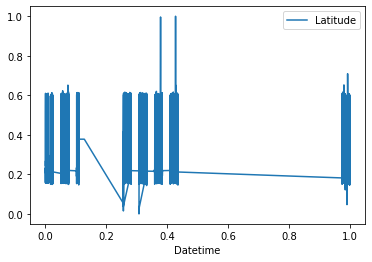

In [107]:
train_df.plot(y='Latitude', x='Datetime')

In [171]:
test_df

,Datetime,Day,Encoded Day,Time,Hour_of_Day,IsEJeep1,IsEJeep2,Altitude,Humidity,Temperature,...,Previous Time to Leong Hall,Encoded Next Station,Next Station Lat,Next Station Long,Next Time to Xavier Hall,Next Time to Fine Arts Annex,Next Time to Loyola House of Studies,Next Time to Grade School,Next Time to Gate 2.5,Next Time to Leong Hall
216657,1.025641,29,1.0,0.000000,6,1.0,0.0,0.219221,0.024509,0.678066,...,0.000000,0.000000,0.999611,0.999964,0.371233,0.377459,0.37373,0.368446,0.370819,0.370964
216658,1.025642,29,1.0,0.000023,6,1.0,0.0,0.219221,0.024509,0.678066,...,0.000000,0.000000,0.999611,0.999964,0.371233,0.377459,0.37373,0.368446,0.370819,0.370964
216659,1.025642,29,1.0,0.000046,6,1.0,0.0,0.219221,0.024509,0.678066,...,0.000000,0.000000,0.999611,0.999964,0.371233,0.377459,0.37373,0.368446,0.370819,0.370964
216660,1.025643,29,1.0,0.000069,6,1.0,0.0,0.219221,0.024509,0.678066,...,0.000000,0.000000,0.999611,0.999964,0.371233,0.377459,0.37373,0.368446,0.370819,0.370964
216661,1.025643,29,1.0,0.000093,6,1.0,0.0,0.219221,0.024509,0.678066,...,0.000000,0.000000,0.999611,0.999964,0.371233,0.377459,0.37373,0.368446,0.370819,0.370964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772376,1.102562,30,0.0,0.999907,17,0.0,1.0,0.446608,0.018231,0.716981,...,1.000793,0.777778,0.999707,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
772377,1.102562,30,0.0,0.999931,17,0.0,1.0,0.445038,0.018231,0.716981,...,1.000793,0.777778,0.999707,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
772378,1.102563,30,0.0,0.999954,17,0.0,1.0,0.442525,0.018231,0.716981,...,1.000793,0.777778,0.999707,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
772379,1.102564,30,0.0,0.999977,17,0.0,1.0,0.439070,0.018231,0.716981,...,1.000793,0.777778,0.999707,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [88]:
df.to_csv('Final_Out.csv')
train_df.to_csv('Train_Out.csv')
test_df.to_csv('Test_Out.csv')
validation_df.to_csv('Validation_Out.csv')

In [108]:
import joblib

joblib.dump(scaler, 'scaler.gz')
# my_scaler = joblib.load('scaler.gz')

['scaler.gz']